<a href="https://colab.research.google.com/github/rcurrie/pancan-gtex/blob/master/infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import json
import requests
import numpy as np
import pandas as pd
!pip install -q tables
import tensorflow as tf
from IPython.core.display import display, HTML

def log(text):
    # Print to notebook and console so we can see in k8s logging
    print(text)
    sys.__stdout__.write(text + "\n")
    sys.__stdout__.flush()
    
# Syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") == "True" else no_debug_param
log(debug("DEBUG: ON", "DEBUG: OFF"))

# Create and switch to a scratch data directory so all paths are local
os.chdir(os.path.expanduser("~/data/treehouse"))

DEBUG: ON


In [2]:
# Load params and model
with open("params.json") as f:  
    params = json.load(f)

model = tf.keras.models.load_model("model.h5")

# Load dataset for SHAP explanations background
X = pd.read_hdf("treehouse-pruned.h5", "samples")
Y = pd.read_hdf("treehouse-pruned.h5", "labels")

W0620 21:44:46.575596 140359733131072 deprecation.py:506] From /tf/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0620 21:44:46.578234 140359733131072 deprecation.py:506] From /tf/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0620 21:44:46.582264 140359733131072 deprecation.py:506] From /tf/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

## Prediction

In [3]:
# Load full original samples and extract the N of 1 - Alternately load the RSEM output of a new sample
all_samples = pd.read_hdf("treehouse.T.fp32.h5")

In [4]:
focus_sample_features = all_samples.loc["TH03_0115_S01"].apply(np.exp2).subtract(1.0).clip(lower=0.0)

# Prune down to genes we trained on and reshape for keras prediction
focus_sample_features = focus_sample_features.drop(set(all_samples.loc["TH03_0115_S01"].index) - set(X.columns.values))
focus_sample_features = focus_sample_features.values.reshape(1,-1)

In [5]:
# predict processes multiple samples and returns a list of predictions
# We just have one so take the first
prediction = model.predict(focus_sample_features)[0]

disease_prediction_index = np.argmax(prediction)
disease_prediction_value = prediction[disease_prediction_index]
disease_prediction_label = params["diseases"][disease_prediction_index]
display(HTML("<h3>Top 3 Disease Predictions (Independant Probabilities)</h3>"))
for p in sorted(zip(prediction, range(len(prediction))), reverse=True)[0:3]:
    display(HTML("<h3>{} ({:.2f})</h3>".format(
        params["diseases"][p[1]].capitalize(), p[0])))

## Explanation 

In [6]:
!pip install --quiet --user shap==0.29.2

import shap
print("SHAP version", shap.__version__)
shap.initjs()

# Select a set of background samples of the same disease to take an expectation over
Y_background = Y[Y.disease == disease_prediction_label]
X_background = X.loc[Y_background.index]
print("Found {} {} training samples".format(X_background.shape[0], disease_prediction_label))

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


SHAP version 0.29.2


Found 606 glioma training samples


In [42]:
%%time
np.random.seed(42)
background = X_background.iloc[np.random.choice(X_background.shape[0], 100, replace=False)]
print("Randomly selecting {} out of {} {} samples as background to compute an expectatin over".format(
    background.shape[0], X_background.shape[0], disease_prediction_label))
explainer = shap.DeepExplainer(model, background)

Randomly selecting 100 out of 606 glioma samples as background to compute an expectatin over
CPU times: user 71.1 ms, sys: 51 ms, total: 122 ms
Wall time: 58.5 ms


In [9]:
%%time
# Explain predictions of model for our focus sample
sample_shap_values = explainer.shap_values(focus_sample_features)
np.save("sample_shap_values.npy", sample_shap_values)

CPU times: user 1min 37s, sys: 4.4 s, total: 1min 41s
Wall time: 1min 40s


In [34]:
sample_shap_values = np.load("sample_shap_values.npy")

### Genes driving focus sample disease classification

In [35]:
shap.force_plot(
    base_value=explainer.expected_value[disease_prediction_index],
    shap_values=sample_shap_values[disease_prediction_index], 
    features=focus_sample_features, 
    feature_names=X_background.columns.values)

### Top Gene's driving disease prediction

In [36]:
max_display = 10
feature_order = np.argsort(np.sum(np.mean(np.abs(sample_shap_values), axis=0), axis=0))
feature_order = feature_order[-min(max_display, len(feature_order)):]
print("Top gene's driving disease prediction")
print([X.columns.values[i] for i in feature_order])

Top gene's driving disease prediction
['MLLT1', 'GABRA2', 'S1PR3', 'HMGB1P1', 'GABRG1', 'AK1', 'PSD2', 'MYLK3', 'B3GAT2', 'AK7']


# Genes driving disease prediction accross all background samples

In [28]:
%%time
# Explain predictions of model for all background samples
background_shap_values = explainer.shap_values(background.values)
np.save("background_shap_values.npy", background_shap_values)

CPU times: user 7min 13s, sys: 9.31 s, total: 7min 22s
Wall time: 7min 18s


In [39]:
background_shap_values = np.load("background_shap_values.npy")

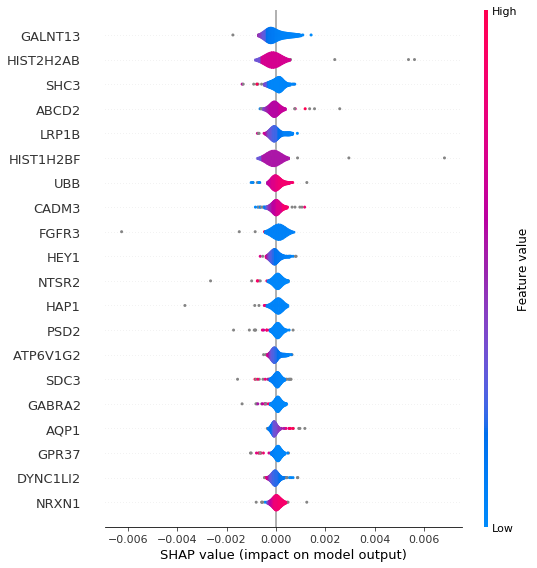

In [43]:
shap.summary_plot(background_shap_values[0], background, plot_type="violin")

### Genes driving disease classification for all background samples

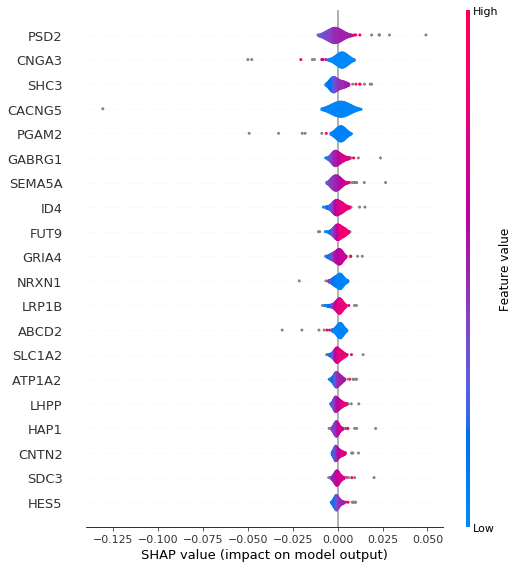

In [44]:
shap.summary_plot(background_shap_values[disease_prediction_index], background, plot_type="violin")

## Most Similar Samples
List closest by spearman distance samples from PanCan along with their relevant prognostic endpoints (OSS etc...)

In [45]:
import scipy
import sklearn.metrics.pairwise as sklp

def nearest_samples(cohort, sample, N=-1):
    """
    Compute the Spearman distance between sample and every member of the
    cohort and return the N nearest samples from the cohort.

    cohort, sample: Pandas data frames with columns=features/genes
    N: the number of most similar samples to return
    """
    # Column wise rank transform to turn correlation into spearman
    cohort_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, cohort.values)
    sample_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, sample)

    # Compute spearman distances
    distances = sklp.pairwise_distances(X=cohort_transformed, Y=sample_transformed, metric="correlation", n_jobs=1)
            
    # Rank and return top N
    rank = 1 - pd.DataFrame(distances, cohort.index.values)
    return rank.sort_values(by=0, ascending=False)[0:N]

nearest = nearest_samples(background, focus_sample_features, 5)
nearest.head()

,0
TCGA-P5-A5EX-01,0.939400
THR14_0316_S01,0.939277
THR19_0460_S01,0.934575
TCGA-DU-7007-01,0.932174
TCGA-HT-7854-01,0.931519
